In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


### Helper Functions: 

In [2]:

def overlay_histograms(ax, arrays, labels, colors, xlabel, title, bin_size = 30, alpha = 0.3, density = True):
    '''
        Overlays one or more histograms on same axes object.

            Parameters:
                    ax: axes object (matplotlib.pyplot)
                    *note: arrays, colors, and labels will be parallel lists
                        arrays (list of arrays): one or more arrays for the x values of each histogram
                        colors (list of strings): colors for each histogram
                        labels (list of strings): labels for each histogram
                    xlabel (string): label for x-axis
                    title (string): title for figure 
                    bin_size (int): default is 30
                    alpha (float): set transparency of plots, default is 0.3    
                    density (bool): normalize for different array lengths, default is True
            Returns:
                    Overlayed histograms on same axes object
    '''
    for arr, lab, col in zip(arrays, labels, colors):
        ax.hist(arr, label = lab, color = col, bins = bin_size, alpha = alpha, density = density)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend()
    return None


def plot_empirical_data(ax, df, column, label = None, color='blue'):
    '''
        Plots the cumulative distribution of a sample. 

            Parameters:
                    ax: axes object (matplotlib.pyplot)
                    df (pandas dataframe)
                    column (series): column within dataframe that contains the data
                    label (string): label for plot
            Returns:
                    A line plot of the sample's cumulative distribution.
    '''    
    
    x = np.arange(int(df[column].min()), int(df[column].max())+1)
    y = ([df[df[column]<=xx][column].sum() for xx in x])/(df[column]).sum()
    data = np.hstack([x,y]).reshape(-1, len(x))
    ax.plot(data[0], data[1], label = label, color = color)

def overlay_plots(ax, dfs, columns, labels, colors, title):
    '''
        Overlays two or more cumulative distribution plots on same axes object.

            Parameters:
                    ax: axes object (matplotlib.pyplot)
                    *note: arrays, colors, and labels should be parallel lists
                        dfs (list of dataframes): where data to be plotted lives
                        columns (list of column names): data from each df to plot
                        colors (array of strings): colors for each plot
                        labels (array of strings): labels for each plot
                    title (string): title for figure   
            Returns:
                    Overlayed cumulative distribution plots on same axes.
    '''
    for df, col, lab, c in zip(dfs, columns, labels, colors):
        plot_empirical_data(ax, df, col, label = lab, color = c)
    ax.set_title(title)
    ax.legend()
    # plt.show()

#Statistical Testing, Two Sample T-Test (independent samples)

def perform_two_samp_ttest(arr1, arr2, alpha = 0.05, equal_var = False):
    '''
        Performs a two-sample t-test for two independent samples.  
        If equal_var = False, it becomes a Welche's test assuming unequal variance.

            Parameters:
                    arr1 (array): sample 1
                    arr2 (array): sample 2
                    alpha (float): significance level (probability of making Type 1 error), default = 0.05
                    equal_var (bool): assume equal variance?
                        if False: performs Welche's t-test (assuming unequal variance)
            Returns:
                    A p-value and whether or not Null should be rejected based on significance level
    '''
    p = stats.ttest_ind(arr1, arr2, equal_var= equal_var)[1]
    if p < alpha:
        return (f"p-value = {p}: Reject the Null Hypothesis")
    else: 
        return (f"p-value = {p} Fail to Reject the Null Hypothesis") 

#MLE For Poisson Distribution
def log_likelihood_poisson(data, lam):
    '''
        Calculates the log likelihood for data, assuming a poisson distribution of a specified lambda.

            Parameters:
                    data (array or series): dataframe column or series
                    lam (int): rate for poisson distribution
                    
            Returns:
                    The log-likelihood of a poisson distribution with lambda = lam producing the data
    '''
    log_lik = -len(data) * lam
    for datum in data:
        log_lik -= math.log(math.factorial(datum)) - (np.log(lam)) * datum
    return log_lik

def mle_poisson(data, lams):
    log_liks = []
    y = np.array(data).astype(int)
    for lam in lams:
        log_liks.append(log_likelihood_poisson(y, lam))
    idx = np.argmax(log_liks)
    return lams[idx]

def paired_bootstrap_sampling(sample1, sample2, num_samples, statistic):
    
    '''
        Takes in two arrays and creates a number of bootstrap samples (num_samples), with replacement, 
        all of length len(array). 
        Returns an array of the bootstrap samples.

            Parameters:
                    sample1 (array): first sample for comparison
                    sample1 (array): second sample for comparison
                    num_samples (int): number of boostrap samples
                    statistic (str): aggregate statistic (i.e. np.median) to perform on each bootstrap sample

            Returns:
                    array (array): differences in median for each boostrap samples
    '''
    bootstraps = []

    for n in range(num_samples):
        samp1 = np.random.choice(sample1, len(sample1), replace = True)
        samp2 = np.random.choice(sample2, len(sample2), replace = True)
        bootstraps.append(statistic(samp1) - statistic(samp2))
        
    return bootstraps

def plot_bs_sample_diffs(ax, sample1, sample2, num_samples, statistic, conf, title, xlabel, alpha = 0.5):
    
    diffs = paired_bootstrap_sampling(sample1, sample2, num_samples, statistic)
    sorted_diffs = sorted(diffs)
    
    ci_lower_limit = sorted_diffs[int(num_samples * (1-conf)/2)]
    ci_upper_limit = sorted_diffs[int(num_samples * ((1-conf)/2 +conf))]
    print(f'lower CI: {ci_lower_limit}, upper CI: {ci_upper_limit}')
    
    ax.hist(diffs, density = True, bins = 20, alpha = alpha)
    ax.axvline(x = ci_lower_limit, linestyle = 'dashed', color = 'blue', label = 'CI Lower')
    ax.axvline(x = ci_upper_limit, linestyle = 'dashed', color = 'green', label = 'CI Upper')
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_ylabel('Density')
    ax.legend()

Importing Data

In [3]:
plt.style.use('ggplot')

In [4]:
raw = pd.read_csv('../data/NeighborhoodFoodRetail.csv')

In [5]:
raw['geoid-tract'] = raw['GEOID10'].astype(str).str[:-1].astype(np.int64)

In [6]:
#Below csv is a way to join census block groups with census tract information.  
#Did not end up using because only average of 3 block groups per tract
'''
number of unique block groups: 1336
number of tracts: 384

'''

census = pd.read_csv('../data/Philadelphia_Census_Tracts_2010_201302.csv')

In [7]:
raw.describe()

,OBJECTID,GEOID10,TOTAL_LPSS,LPSS_PER1000,TOTAL_HPSS,HPSS_PER1000,PCT_HPSS,PCT_VEHICLE_AVAILABILITY,TOTAL_RESTAURANTS,PCT_POVERTY,Shape__Area,Shape__Length,geoid-tract
count,1336.00000,1.336000e+03,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1326.000000,1336.000000,1327.000000,1.336000e+03,1336.000000,1.336000e+03
mean,668.50000,4.210103e+11,29.661132,31.087562,3.787736,3.817164,11.819979,68.049988,4.822605,26.520875,4.711942e+05,2735.171689,4.210103e+10
std,385.81429,8.764745e+05,19.908910,25.752759,4.542649,4.948151,9.602760,20.025984,11.213721,18.830053,1.420624e+06,2567.587028,8.764746e+04
min,1.00000,4.210100e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.854482e+04,714.420557,4.210100e+10
25%,334.75000,4.210101e+11,16.000000,13.045099,1.250000,1.238646,5.555556,53.727012,1.000000,11.043445,1.392045e+05,1621.215675,4.210101e+10
50%,668.50000,4.210102e+11,27.000000,24.469821,2.750000,2.557981,9.677419,69.917338,2.000000,22.905028,2.124640e+05,2081.372899,4.210102e+10
75%,1002.25000,4.210103e+11,39.000000,41.792853,4.250000,4.507212,15.789474,84.387384,5.000000,39.300387,3.887246e+05,3000.982831,4.210103e+10
max,1336.00000,4.210199e+11,148.000000,224.615385,32.000000,62.992126,80.952381,100.000000,174.000000,92.452830,3.497850e+07,40155.296102,4.210199e+10


In [8]:
census.describe()

,OBJECTID_1,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,Shape_Length,Shape_Area
count,384.000000,384.000000,384.0,384.0,384.000000,3.840000e+02,384.000000,3.840000e+02,3.840000e+02,384.000000,384.000000,384.000000,384.000000,3.840000e+02
mean,192.500000,192.500000,42.0,101.0,47178.580729,4.210105e+10,471.785807,9.044821e+05,5.804533e+04,40.001359,-75.147337,10526.500000,13951.435081,1.034069e+07
std,110.995495,110.995495,0.0,0.0,161029.335452,1.610293e+05,1610.293355,1.254499e+06,3.247725e+05,0.052339,0.067570,110.995495,10239.117259,1.605469e+07
min,1.000000,1.000000,42.0,101.0,100.000000,4.210100e+10,1.000000,9.995800e+04,0.000000e+00,39.879890,-75.267904,10335.000000,4342.558559,1.135601e+06
25%,96.750000,96.750000,42.0,101.0,9575.000000,4.210101e+10,95.750000,3.974568e+05,0.000000e+00,39.957579,-75.193832,10430.750000,8971.319654,4.288051e+06
50%,192.500000,192.500000,42.0,101.0,20101.500000,4.210102e+10,201.015000,6.003620e+05,0.000000e+00,39.999032,-75.159724,10526.500000,11232.172295,6.459285e+06
75%,288.250000,288.250000,42.0,101.0,31101.250000,4.210103e+10,311.012500,9.554520e+05,0.000000e+00,40.042847,-75.110631,10622.250000,15276.435312,1.039250e+07
max,384.000000,384.000000,42.0,101.0,989100.000000,4.210199e+10,9891.000000,1.722870e+07,3.463789e+06,40.129088,-74.966739,10718.000000,100989.528600,2.213233e+08


In [9]:
census.sort_values('GEOID10')

,OBJECTID_1,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,Shape_Length,Shape_Area
144,145,190,42,101,100,42101000100,1.00,Census Tract 1,G5020,S,704909,0,39.952383,-75.146663,10335,11381.432670,7.595557e+06
145,146,191,42,101,200,42101000200,2.00,Census Tract 2,G5020,S,382478,0,39.955400,-75.156977,10336,9279.187946,4.116628e+06
146,147,192,42,101,300,42101000300,3.00,Census Tract 3,G5020,S,548342,356,39.956878,-75.171666,10337,12679.901660,5.887110e+06
99,100,145,42,101,401,42101000401,4.01,Census Tract 4.01,G5020,S,214766,14981,39.954187,-75.175808,10338,6872.912592,2.513119e+06
98,99,144,42,101,402,42101000402,4.02,Census Tract 4.02,G5020,S,303680,0,39.953297,-75.168695,10339,8922.261202,3.268872e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,262,306,42,101,980600,42101980600,9806.00,Census Tract 9806,G5020,S,1286624,0,39.905538,-75.170715,10714,21279.820640,1.385038e+07
259,260,304,42,101,980700,42101980700,9807.00,Census Tract 9807,G5020,S,5957147,1730038,39.910468,-75.143166,10715,48820.671370,8.087268e+07
279,280,324,42,101,980800,42101980800,9808.00,Census Tract 9808,G5020,S,2106698,43823,39.971452,-75.262177,10716,41365.548380,2.336726e+07
254,255,299,42,101,980900,42101980900,9809.00,Census Tract 9809,G5020,S,17228698,3463789,39.905180,-75.217415,10717,100989.528600,2.213233e+08


In [10]:
raw.sort_values('GEOID10')

,OBJECTID,GEOID10,NON_RESIDENTIAL,TOTAL_LPSS,LPSS_PER1000,TOTAL_HPSS,HPSS_PER1000,PCT_HPSS,HPSS_ACCESS,SUPERMARKET_ACCESS,PCT_VEHICLE_AVAILABILITY,TOTAL_RESTAURANTS,PCT_POVERTY,HIGH_POVERTY,Shape__Area,Shape__Length,geoid-tract
403,404,421010001001,No,40.0,20.931449,6.50,3.401361,13.978495,Moderate or High Access,Yes,64.334471,116,7.587650,No,4.185576e+05,2640.024260,42101000100
180,181,421010001002,No,66.0,29.411765,13.00,5.793226,16.455696,Moderate or High Access,Yes,82.259414,35,6.550802,No,7.837095e+05,4510.466573,42101000100
187,188,421010002001,No,120.0,44.726053,17.75,6.615729,12.885662,Moderate or High Access,Yes,51.782178,105,37.607506,Yes,6.516972e+05,3688.952987,42101000200
207,208,421010003001,No,120.0,131.868132,20.50,22.527473,14.590747,Moderate or High Access,Yes,47.816594,52,8.760951,No,5.501606e+05,3188.700686,42101000300
302,303,421010003002,No,62.0,23.628049,14.75,5.621189,19.218241,Moderate or High Access,Yes,64.142539,8,8.346582,No,3.819913e+05,2856.746779,42101000300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,377,421019806001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2.189288e+06,8458.313890,42101980600
212,213,421019807001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,1.278324e+07,19410.087844,42101980700
384,385,421019808001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3.701706e+06,16464.480283,42101980800
210,211,421019809001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,3.497850e+07,40155.296102,42101980900


## Initial Look

In [11]:
raw.columns

Index(['OBJECTID', 'GEOID10', 'NON_RESIDENTIAL', 'TOTAL_LPSS', 'LPSS_PER1000',
       'TOTAL_HPSS', 'HPSS_PER1000', 'PCT_HPSS', 'HPSS_ACCESS',
       'SUPERMARKET_ACCESS', 'PCT_VEHICLE_AVAILABILITY', 'TOTAL_RESTAURANTS',
       'PCT_POVERTY', 'HIGH_POVERTY', 'Shape__Area', 'Shape__Length',
       'geoid-tract'],
      dtype='object')

In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1336 entries, 0 to 1335
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OBJECTID                  1336 non-null   int64  
 1   GEOID10                   1336 non-null   int64  
 2   NON_RESIDENTIAL           1336 non-null   object 
 3   TOTAL_LPSS                1325 non-null   float64
 4   LPSS_PER1000              1325 non-null   float64
 5   TOTAL_HPSS                1325 non-null   float64
 6   HPSS_PER1000              1325 non-null   float64
 7   PCT_HPSS                  1325 non-null   float64
 8   HPSS_ACCESS               1325 non-null   object 
 9   SUPERMARKET_ACCESS        1325 non-null   object 
 10  PCT_VEHICLE_AVAILABILITY  1326 non-null   float64
 11  TOTAL_RESTAURANTS         1336 non-null   int64  
 12  PCT_POVERTY               1327 non-null   float64
 13  HIGH_POVERTY              1327 non-null   object 
 14  Shape__A

In [13]:
#adjust column names, drop objectid (use GEOID10 as unique identifier)

raw.columns = ['id', 'geoid', 'non_res', 'tot_lpss', 'lpss_per_1000',
       'tot_hpss', 'hpss_per_1000', 'pct_hpss', 'hpss_access',
       'sprmkt_access', 'pct_vehicle_avail', 'tot_restaurants',
       'pct_poverty', 'high_poverty', 'area', 'length', 'geoid-tract']

raw.drop('id', axis = 1, inplace = True)

raw.columns

Index(['geoid', 'non_res', 'tot_lpss', 'lpss_per_1000', 'tot_hpss',
       'hpss_per_1000', 'pct_hpss', 'hpss_access', 'sprmkt_access',
       'pct_vehicle_avail', 'tot_restaurants', 'pct_poverty', 'high_poverty',
       'area', 'length', 'geoid-tract'],
      dtype='object')

In [14]:
raw.head()

,geoid,non_res,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,hpss_access,sprmkt_access,pct_vehicle_avail,tot_restaurants,pct_poverty,high_poverty,area,length,geoid-tract
0,421010108001,No,25.0,30.674847,2.50,3.067485,9.090909,Moderate or High Access,Yes,44.268775,0,54.969325,Yes,275942.097656,3260.316044,42101010800
1,421010108002,No,21.0,28.806584,1.75,2.400549,7.692308,Moderate or High Access,Yes,67.611336,2,37.860082,Yes,176880.882812,1736.152373,42101010800
2,421010109002,No,7.0,17.114914,0.50,1.222494,6.666667,Low Access,No,37.356322,1,57.212714,Yes,74520.027344,1211.853466,42101010900
3,421010110002,No,15.0,19.480519,2.75,3.571429,15.492958,Moderate or High Access,Yes,52.824859,0,19.480519,No,185771.992188,2057.362419,42101011000
4,421010110001,No,17.0,25.914634,2.50,3.810976,12.820513,Moderate or High Access,Yes,70.408163,1,52.134146,Yes,242486.906250,4166.159591,42101011000


## Handling Null Data:

* 11 Null values in columns: 'tot_lpss', 'lpss_per_1000', 'tot_hpss',
       'hpss_per_1000', 'pct_hpss', 'hpss_access', 'sprmkt_access'
       
* 10 Null values in columns: 'pct_vehicle_avail'
* 9 Null values in columns: 'pct_poverty'

In [15]:
# Looking at 11 nulls for **SS categories: All Non-residential 

print(f'Number of Null Rows: {len(raw[raw["tot_lpss"].isna()])}')

raw[raw['tot_lpss'].isna()]

Number of Null Rows: 11


,geoid,non_res,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,hpss_access,sprmkt_access,pct_vehicle_avail,tot_restaurants,pct_poverty,high_poverty,area,length,geoid-tract
57,421010050001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,1.395457e+07,19077.397532,42101005000
190,421019805001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.091363e+05,3497.167229,42101980500
210,421019809001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,3.497850e+07,40155.296102,42101980900
212,421019807001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,1.278324e+07,19410.087844,42101980700
213,421019801001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.452830,3,13.265306,No,1.006789e+07,39471.537984,42101980100
283,421019800001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.604396,36,4.945055,No,1.780644e+07,27702.726031,42101980000
369,421019802001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.956522,1,11.455108,No,9.214561e+06,34834.687659,42101980200
376,421019806001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2.189288e+06,8458.313890,42101980600
384,421019808001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3.701706e+06,16464.480283,42101980800
701,421019803001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,1.303118e+07,14608.573156,42101980300


In [16]:
# Looking at nulls for pct_poverty:

print(f'Number of Null Rows: {len(raw[raw["pct_poverty"].isna()])}')

raw[raw['pct_poverty'].isna()]

Number of Null Rows: 9


,geoid,non_res,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,hpss_access,sprmkt_access,pct_vehicle_avail,tot_restaurants,pct_poverty,high_poverty,area,length,geoid-tract
57,421010050001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,1.395457e+07,19077.397532,42101005000
183,421010369001,No,27.0,212.598425,8.0,62.992126,22.857143,Moderate or High Access,Yes,NaN,36,NaN,NaN,8.377759e+05,5412.929429,42101036900
190,421019805001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.091363e+05,3497.167229,42101980500
210,421019809001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,3.497850e+07,40155.296102,42101980900
212,421019807001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,1.278324e+07,19410.087844,42101980700
376,421019806001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2.189288e+06,8458.313890,42101980600
384,421019808001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3.701706e+06,16464.480283,42101980800
701,421019803001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,1.303118e+07,14608.573156,42101980300
1019,421019804001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,5.056550e+06,13040.204472,42101980400


In [17]:
# Looking at nulls for pct_vehicle_avail:

print(f'Number of Null Rows: {len(raw[raw["pct_vehicle_avail"].isna()])}')

raw[raw['pct_vehicle_avail'].isna()]

Number of Null Rows: 10


,geoid,non_res,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,hpss_access,sprmkt_access,pct_vehicle_avail,tot_restaurants,pct_poverty,high_poverty,area,length,geoid-tract
57,421010050001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,1.395457e+07,19077.397532,42101005000
183,421010369001,No,27.0,212.598425,8.0,62.992126,22.857143,Moderate or High Access,Yes,NaN,36,NaN,NaN,8.377759e+05,5412.929429,42101036900
190,421019805001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,7.091363e+05,3497.167229,42101980500
210,421019809001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,NaN,NaN,3.497850e+07,40155.296102,42101980900
212,421019807001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,NaN,NaN,1.278324e+07,19410.087844,42101980700
376,421019806001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2.189288e+06,8458.313890,42101980600
384,421019808001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3.701706e+06,16464.480283,42101980800
701,421019803001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN,1.303118e+07,14608.573156,42101980300
829,421019891001,No,5.0,1.971609,0.0,0.000000,0.000000,No Access,No,NaN,3,92.45283,Yes,7.014906e+06,12283.283540,42101989100
1019,421019804001,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,5.056550e+06,13040.204472,42101980400


Observation: most of null values are shared across columns and are non-residential.
They will not add insight to our analysis.  These 13 total rows will be dropped from the initial raw dataset.  
New dataframe will be called "df".

In [18]:
df = raw.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 1335
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   geoid              1323 non-null   int64  
 1   non_res            1323 non-null   object 
 2   tot_lpss           1323 non-null   float64
 3   lpss_per_1000      1323 non-null   float64
 4   tot_hpss           1323 non-null   float64
 5   hpss_per_1000      1323 non-null   float64
 6   pct_hpss           1323 non-null   float64
 7   hpss_access        1323 non-null   object 
 8   sprmkt_access      1323 non-null   object 
 9   pct_vehicle_avail  1323 non-null   float64
 10  tot_restaurants    1323 non-null   int64  
 11  pct_poverty        1323 non-null   float64
 12  high_poverty       1323 non-null   object 
 13  area               1323 non-null   float64
 14  length             1323 non-null   float64
 15  geoid-tract        1323 non-null   int64  
dtypes: float64(9), int64(3),

In [19]:
df.describe()

,geoid,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,pct_vehicle_avail,tot_restaurants,pct_poverty,area,length,geoid-tract
count,1.323000e+03,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03,1323.000000,1.323000e+03
mean,4.210102e+11,29.681784,30.972374,3.787415,3.775322,11.820571,67.996425,4.738473,26.508755,3.765455e+05,2569.745043,4.210102e+10
std,1.133177e+05,19.912270,25.271168,4.543413,4.675435,9.599723,20.016295,11.137889,18.753629,5.860417e+05,1567.624466,1.133177e+04
min,4.210100e+11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.854482e+04,714.420557,4.210100e+10
25%,4.210101e+11,16.000000,13.070168,1.250000,1.239927,5.555556,53.694266,1.000000,11.043445,1.385243e+05,1617.945640,4.210101e+10
50%,4.210102e+11,27.000000,24.469821,2.750000,2.557981,9.677419,69.856459,2.000000,22.909091,2.119770e+05,2071.517104,4.210102e+10
75%,4.210103e+11,39.000000,41.753900,4.250000,4.505858,15.789474,84.330495,5.000000,39.300387,3.811675e+05,2974.440984,4.210103e+10
max,4.210104e+11,148.000000,224.615385,32.000000,47.339593,80.952381,100.000000,174.000000,88.194444,8.317655e+06,15886.036994,4.210104e+10


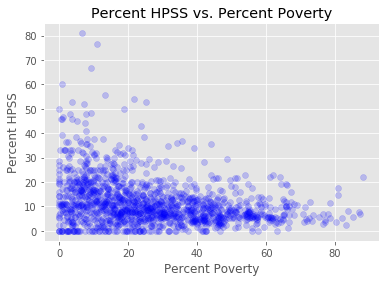

In [20]:
fig, ax = plt.subplots()
ax.scatter(df['pct_poverty'], df['pct_hpss'], alpha = 0.2, color = 'blue')
ax.set_xlabel('Percent Poverty')
ax.set_ylabel('Percent HPSS')
ax.set_title('Percent HPSS vs. Percent Poverty');


## Supermarket Access: Is there an Impact? 

Split dataframe based on sprmrkt_access (Yes or No)

In [22]:
sprmkt_access = df[df['sprmkt_access']=='Yes']
len(sprmkt_access)

1051

In [23]:
no_sprmkt_access = df[df['sprmkt_access']=='No']
len(no_sprmkt_access)

272

In [24]:
print(f"% Poverty WITH Super Market Access:  \n Mean: {sprmkt_access['pct_poverty'].mean()}  \n Standard Deviation: {sprmkt_access['pct_poverty'].std()}")

print(f"\n \n % Poverty WITHOUT Super Market Access:  \n Mean: {no_sprmkt_access['pct_poverty'].mean()}  \n Standard Deviation: {no_sprmkt_access['pct_poverty'].std()}")

% Poverty WITH Super Market Access:  
 Mean: 26.90533879603233  
 Standard Deviation: 18.924319713806238

 
 % Poverty WITHOUT Super Market Access:  
 Mean: 24.976368040845596  
 Standard Deviation: 18.030845828927923


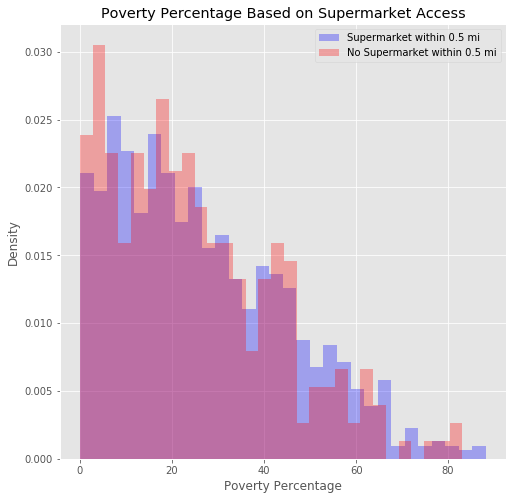

In [25]:
fig, ax = plt.subplots(figsize = (8, 8))
data = [sprmkt_access['pct_poverty'], no_sprmkt_access['pct_poverty']]
labels = ['Supermarket within 0.5 mi', 'No Supermarket within 0.5 mi']
colors = ['blue', 'red']

#from functionalization.py
overlay_histograms(ax, data, labels, colors, xlabel = 'Poverty Percentage', title = 'Poverty Percentage Based on Supermarket Access')
ax.set_ylabel('Density')
plt.show();


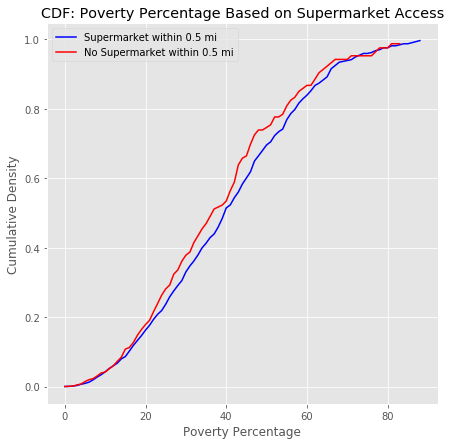

In [26]:

dfs_c = [sprmkt_access, no_sprmkt_access]
colors = ['blue', 'red']
columns_c = ['pct_poverty', 'pct_poverty']
labels_c = ['Supermarket within 0.5 mi', 'No Supermarket within 0.5 mi']
fig, ax = plt.subplots(figsize = (7,7))
ax.set_xlabel('Poverty Percentage')
ax.set_ylabel('Cumulative Density')

overlay_plots(ax, dfs_c, columns_c, labels_c, colors, 'CDF: Poverty Percentage Based on Supermarket Access')
# fig.savefig('images/CDF_pct_pov_by_supermarket.jpeg')
plt.show();

### Closer Look: Poverty Percentage

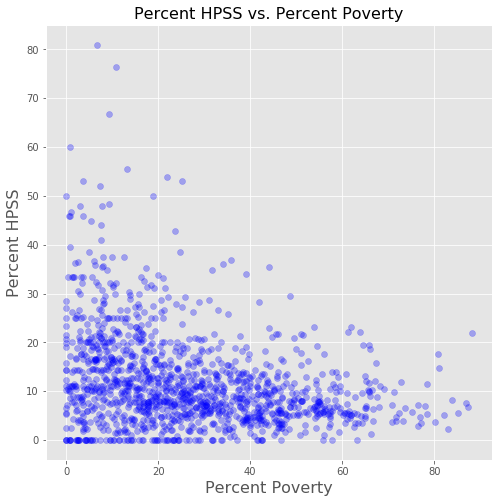

In [75]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(df['pct_poverty'], df['pct_hpss'], alpha = 0.3, color = 'blue')
ax.set_xlabel('Percent Poverty', fontsize = 16)
ax.set_ylabel('Percent HPSS', fontsize = 16)
ax.set_title('Percent HPSS vs. Percent Poverty', fontsize = 16)
fig.savefig('../images/scatter_pct_hpss_by_pov.jpeg');

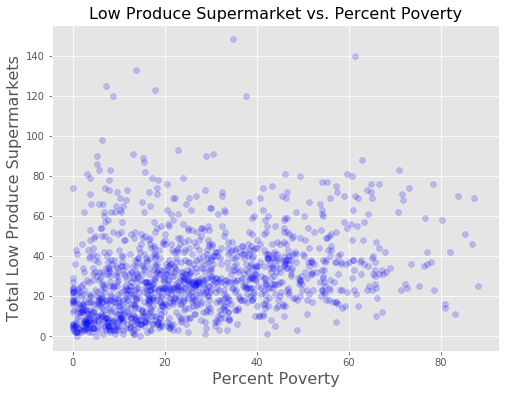

In [57]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(df['pct_poverty'], df['tot_lpss'], alpha = 0.2, color = 'blue')
ax.set_xlabel('Percent Poverty', fontsize = 16)
ax.set_ylabel('Total Low Produce Supermarkets', fontsize = 16)
ax.set_title('Low Produce Supermarket vs. Percent Poverty', fontsize = 16);
fig.savefig('../images/scatter_tot_lpss.jpeg')


### Vehicle Access based on Supermarket Access

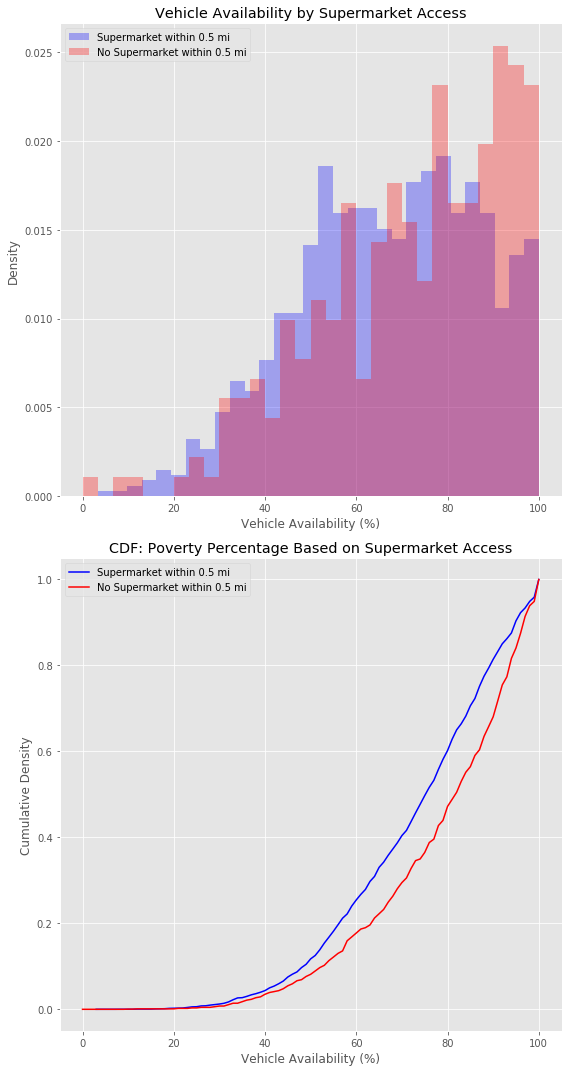

In [29]:
fig, ax = plt.subplots(2, figsize = (8, 15))
data = [sprmkt_access['pct_vehicle_avail'], no_sprmkt_access['pct_vehicle_avail']]
labels = ['Supermarket within 0.5 mi', 'No Supermarket within 0.5 mi']
colors = ['blue', 'red']
overlay_histograms(ax[0], data, labels, colors, xlabel = 'Vehicle Availability (%)', title = 'Vehicle Availability by Supermarket Access')
ax[0].set_ylabel('Density')

dfs_c = [sprmkt_access, no_sprmkt_access]
columns_c = ['pct_vehicle_avail', 'pct_vehicle_avail']
labels_c = ['Supermarket within 0.5 mi', 'No Supermarket within 0.5 mi']
ax[1].set_xlabel('Vehicle Availability (%)')
ax[1].set_ylabel('Cumulative Density')

overlay_plots(ax[1], dfs_c, columns_c, labels_c, colors, 'CDF: Poverty Percentage Based on Supermarket Access')


# fig.savefig('images/pdfandcdf_pct_vehicle_by_supermarket.jpeg')
fig.tight_layout()
plt.show();

Comparison of Means: 
Using bootstrapping method: 5,000 samples per group
Take mean of bootstrap sample and plot difference below.  
95% confidence intervals plotted below.  Does not include 0 so we can be 95% confident that there is a difference in means. 

lower CI: 2.37197996317623, upper CI: 7.786113687360867


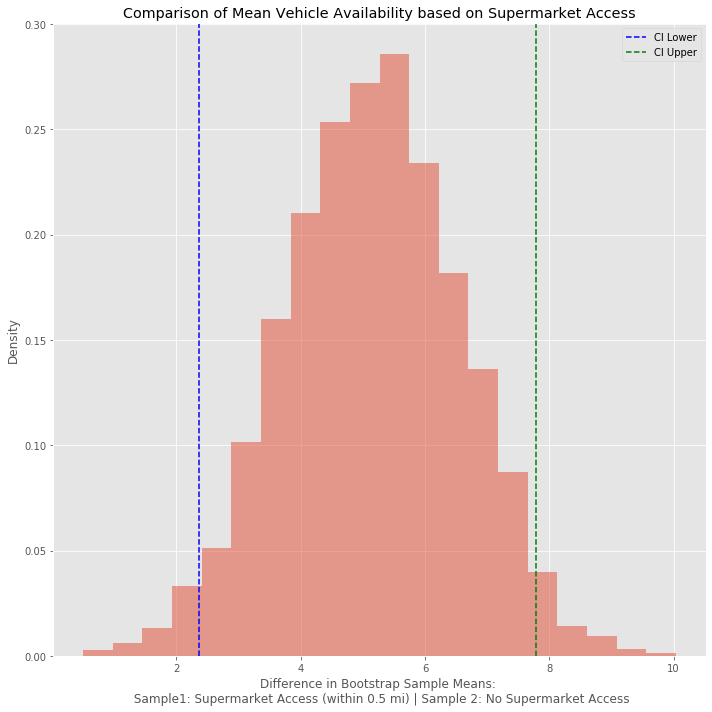

In [30]:
fig, ax = plt.subplots(figsize = (10, 10))
plot_bs_sample_diffs(ax, no_sprmkt_access['pct_vehicle_avail'], sprmkt_access['pct_vehicle_avail'], 5000, np.mean, .95, 'Comparison of Mean Vehicle Availability based on Supermarket Access', 'Difference in Bootstrap Sample Means: \n Sample1: Supermarket Access (within 0.5 mi) | Sample 2: No Supermarket Access')
fig.tight_layout()
# fig.savefig('images/Veh_avail_supermarkets_compare_means.jpeg')




In [31]:
print(f"Vehicle Availablility WITH Super Market Access:  \n Mean: {np.mean(sprmkt_access['pct_vehicle_avail'])} \n Median: {np.median(sprmkt_access['pct_vehicle_avail'])} \n Standard Deviation: {np.std(sprmkt_access['pct_vehicle_avail'], ddof = 1)}")

print(f"\n \n Vehicle Availablility WITHOUT Super Market Access:  \n Mean: {no_sprmkt_access['pct_vehicle_avail'].mean()} \n Median: {no_sprmkt_access['pct_vehicle_avail'].median()} \n Standard Deviation: {np.std(no_sprmkt_access['pct_vehicle_avail'], ddof = 1)}")

Vehicle Availablility WITH Super Market Access:  
 Mean: 66.93586329526163 
 Median: 68.16143498 
 Standard Deviation: 19.761411173992382

 
 Vehicle Availablility WITHOUT Super Market Access:  
 Mean: 72.09440593992645 
 Median: 75.74018451 
 Standard Deviation: 20.498673409248337


### Look at Poverty Classification
* High poverty: areas where >20% of residents are below the federal poverty line

In [32]:
#create data frames based on poverty classification

high_pov = df[df['high_poverty']=='Yes']
not_high_pov = df[df['high_poverty']=='No']

##### High Produce Supply Stores per 1,000 Residents based on Poverty Classification

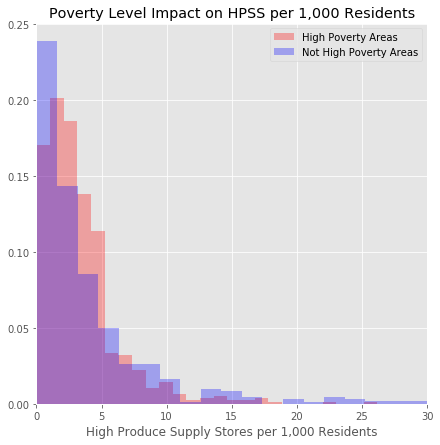

In [33]:
fig, ax = plt.subplots(figsize = (7,7))

data = [high_pov['hpss_per_1000'], not_high_pov['hpss_per_1000']]
labels = ['High Poverty Areas', 'Not High Poverty Areas']
colors = ['red', 'blue']

#from functionalization.py
overlay_histograms(ax, data, labels, colors, xlabel = 'High Produce Supply Stores per 1,000 Residents', title = 'Poverty Level Impact on HPSS per 1,000 Residents')
ax.set_xlim(0, 30);

In [34]:
print(f"High Poverty Areas: HPSS per 1,000 Residents  \n Mean: {high_pov['hpss_per_1000'].mean()}  \n Standard Deviation: {high_pov['hpss_per_1000'].std(ddof = 1)} \n Median: {high_pov['hpss_per_1000'].median()}")
print(f"\n \n Not High Poverty Areas: HPSS per 1,000 Residents  \n Mean: {not_high_pov['hpss_per_1000'].mean()}  \n Standard Deviation: {not_high_pov['hpss_per_1000'].std(ddof = 1)} \n Median: {not_high_pov['hpss_per_1000'].median()}")


High Poverty Areas: HPSS per 1,000 Residents  
 Mean: 3.3916691824357206  
 Standard Deviation: 3.1997347866450787 
 Median: 2.68048606

 
 Not High Poverty Areas: HPSS per 1,000 Residents  
 Mean: 4.260799822654104  
 Standard Deviation: 6.015450479604703 
 Median: 2.3598893949999997


In [35]:
len(high_pov)

739

In [36]:
len(not_high_pov)

584

##### Low Produce Supply Stores per 1,000 Residents based on Poverty Classification

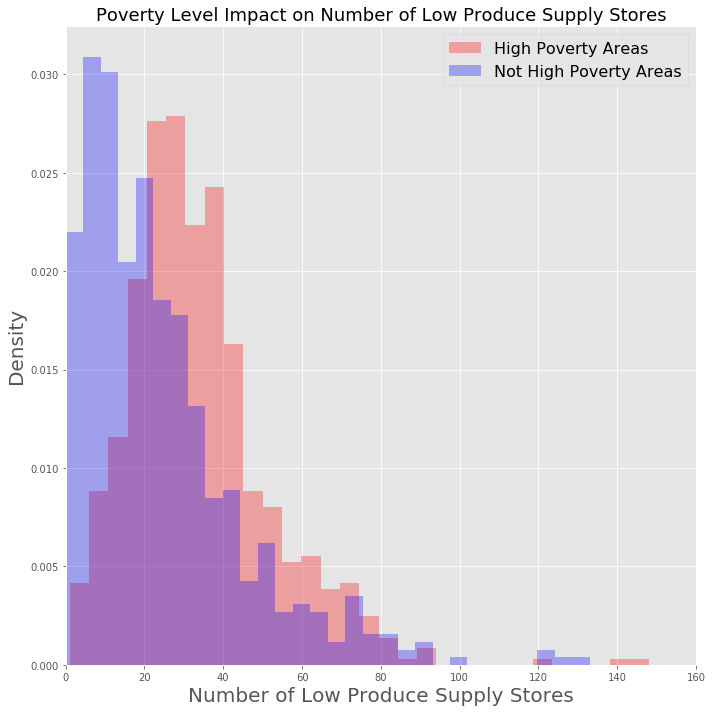

In [37]:
fig, ax = plt.subplots(figsize = (10,10))

data = [high_pov['tot_lpss'], not_high_pov['tot_lpss']]
labels = ['High Poverty Areas', 'Not High Poverty Areas']
colors = ['red', 'blue']

#from functionalization.py
overlay_histograms(ax, data, labels, colors, xlabel = 'Number of Low Produce Supply Stores', title = 'Poverty Level Impact on Number of Low Produce Supply Stores')
ax.set_xlim(0, 160)
ax.set_ylabel('Density', fontsize = 20)
ax.set_xlabel('Number of Low Produce Supply Stores', fontsize = 20)
ax.set_title('Poverty Level Impact on Number of Low Produce Supply Stores', fontsize = 18)
fig.tight_layout()
ax.legend(fontsize = 16)
# fig.savefig('../images/pdf_tot_lpss_by_poverty.jpeg');

In [38]:
print(f"High Poverty Areas: LPSS per 1,000 Residents  \n Mean: {high_pov['lpss_per_1000'].mean()}  \n Standard Deviation: {high_pov['lpss_per_1000'].std(ddof = 1)}")
print(f"\n \n Not High Poverty Areas: LPSS per 1,000 Residents  \n Mean: {not_high_pov['lpss_per_1000'].mean()}  \n Standard Deviation: {not_high_pov['lpss_per_1000'].std(ddof = 1)}")


High Poverty Areas: LPSS per 1,000 Residents  
 Mean: 35.69629936443842  
 Standard Deviation: 25.303419912292952

 
 Not High Poverty Areas: LPSS per 1,000 Residents  
 Mean: 24.99466610030821  
 Standard Deviation: 23.94956353088885


#### HPSS Percentage based on Poverty Classification

* Percent HPSS = HPSS / (HPSS + LPSS)

## Compare Median %HPSS based on Poverty Classification

Chose medians over mean due to several outliers (right skewed histograms - see below)

Method: 
Non normal distributions.  In order to create a normal distribution, I plan to use bootstrapping (5,000 samples). For each bootstrap sample from each group, I will take the difference in medians, then plot those differences.  The upper and lower confidence limits will be plotted based on a specified confidence interval. If zero is within the confidence limits, I cannot reject the null hypothesis. 

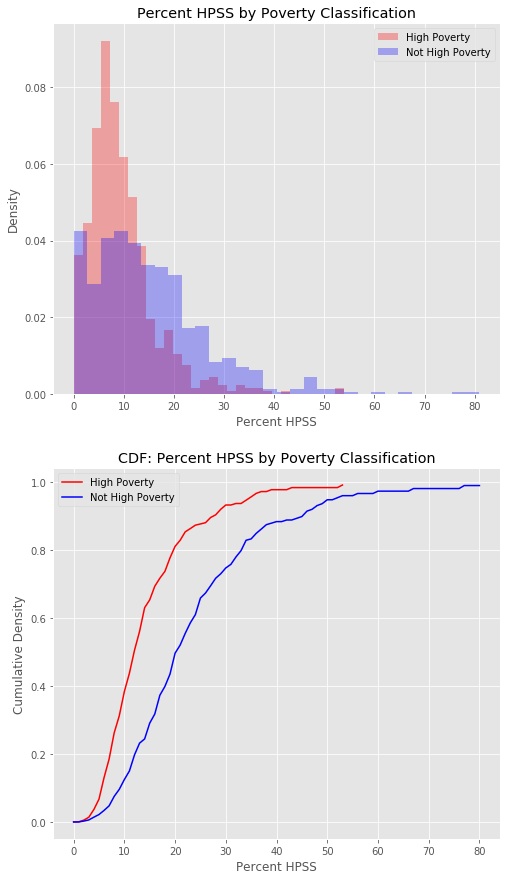

In [39]:
fig, ax = plt.subplots(2, figsize = (8, 15))
data = [high_pov['pct_hpss'], not_high_pov['pct_hpss']]
labels = ['High Poverty', 'Not High Poverty']
colors = ['red', 'blue']
overlay_histograms(ax[0], data, labels, colors, xlabel = 'Percent HPSS', title = 'Percent HPSS by Poverty Classification')
ax[0].set_ylabel('Density')

dfs_c = [high_pov, not_high_pov]
columns_c = ['pct_hpss', 'pct_hpss']
labels_c = ['High Poverty', 'Not High Poverty']
ax[1].set_xlabel('Percent HPSS')
ax[1].set_ylabel('Cumulative Density')

overlay_plots(ax[1], dfs_c, columns_c, labels_c, colors, 'CDF: Percent HPSS by Poverty Classification')


# fig.savefig('images/pdfandcdf_pct_HPSS_by_poverty.jpeg', pad_inches = 0)
plt.show();

lower CI: -6.341831495000001, upper CI: -3.6390315500000003


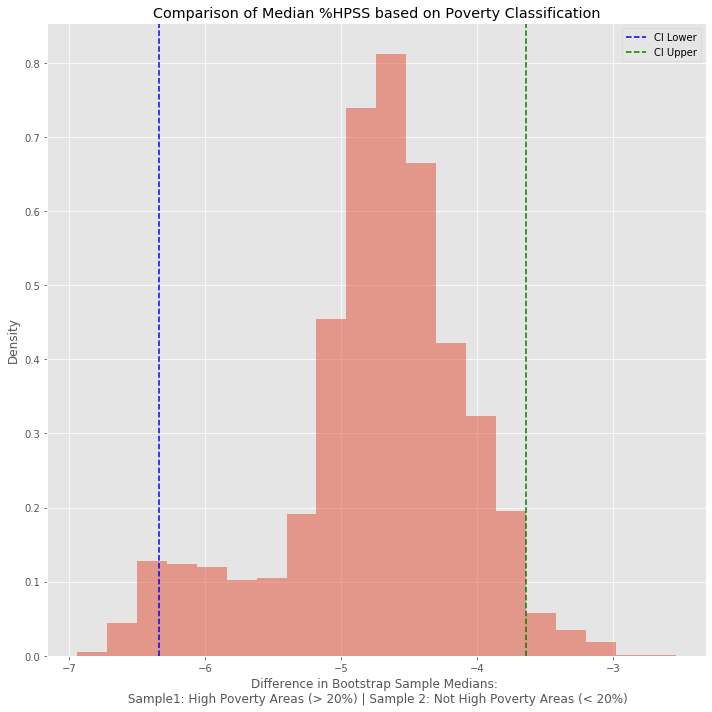

In [40]:
fig, ax = plt.subplots(figsize = (10, 10))
plot_bs_sample_diffs(ax, high_pov['pct_hpss'], not_high_pov['pct_hpss'], 10000, np.median, .95, 'Comparison of Median %HPSS based on Poverty Classification', 'Difference in Bootstrap Sample Medians: \n Sample1: High Poverty Areas (> 20%) | Sample 2: Not High Poverty Areas (< 20%)')
fig.tight_layout()
# fig.savefig('images/Percent_HPSS_compare_medians.jpeg')




In [41]:
#summary stats for %hpss based on poverty classification

print(f"High Poverty Areas: HPSS Percentage  \n Mean: {high_pov['pct_hpss'].mean()}  \n Standard Deviation: {high_pov['pct_hpss'].std(ddof = 1)} \n Variance High Pov: {high_pov['pct_hpss'].var(ddof =1)}")

print(f"\n \n Not High Poverty Areas: HPSS Percentage  \n Mean: {not_high_pov['pct_hpss'].mean()}  \n Standard Deviation: {not_high_pov['pct_hpss'].std(ddof = 1)} \n Variance Not High Pov: {not_high_pov['pct_hpss'].var(ddof = 1)}")



High Poverty Areas: HPSS Percentage  
 Mean: 9.412744631583218  
 Standard Deviation: 6.847574515657955 
 Variance High Pov: 46.88927674748828

 
 Not High Poverty Areas: HPSS Percentage  
 Mean: 14.867461035256857  
 Standard Deviation: 11.53101311872929 
 Variance Not High Pov: 132.964263544307


##### What do the cumulative density functions look like for %HPSS based on Poverty Classification?

### Look at Potential Correlations within Dataset

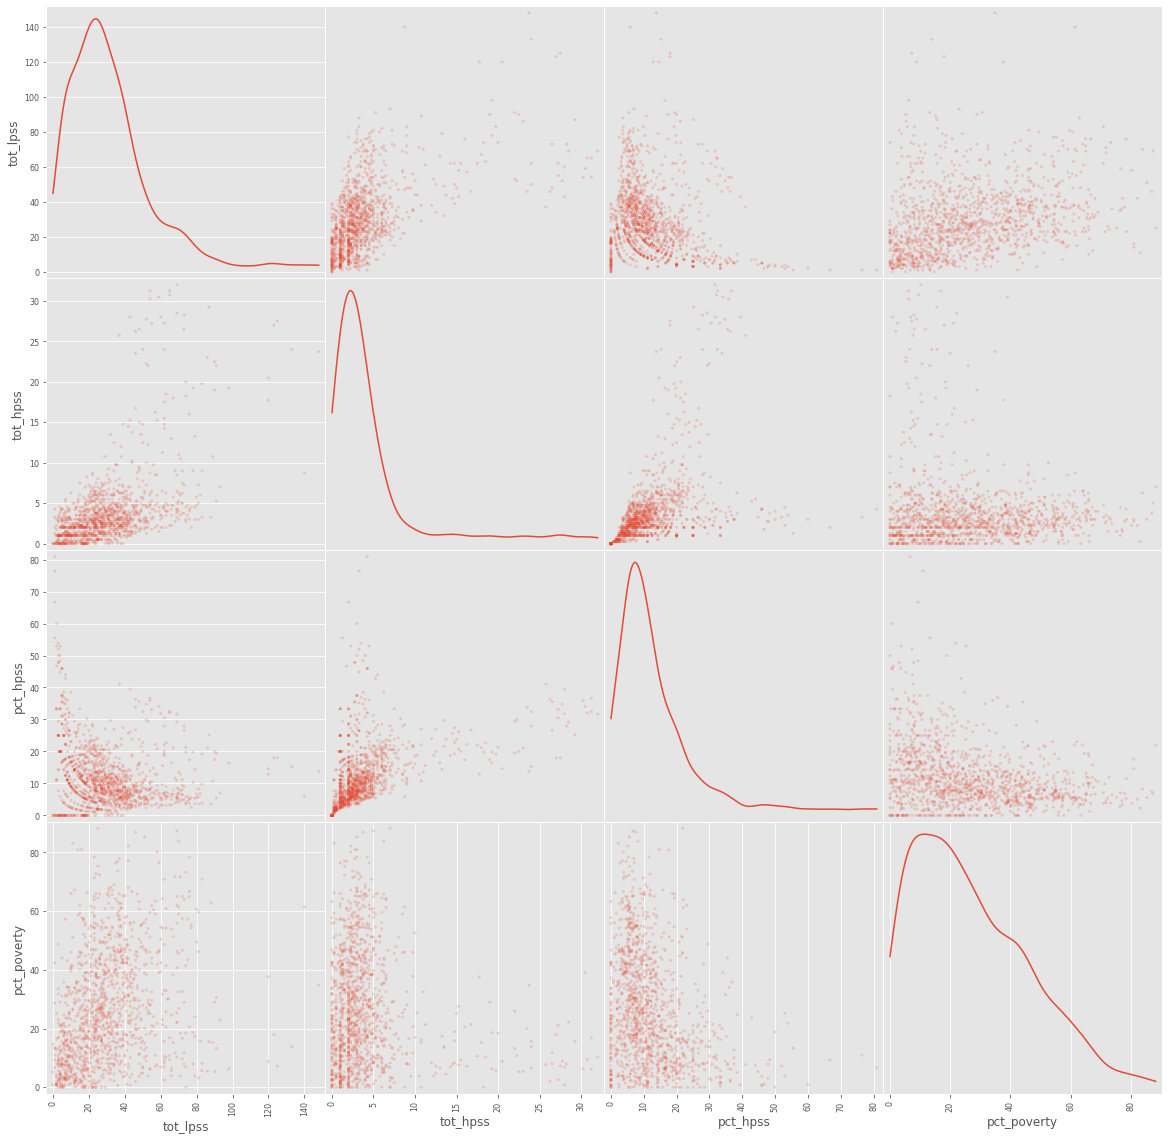

In [66]:
from pandas.plotting import scatter_matrix
scatter_cols = ['tot_lpss', 'tot_hpss', 'pct_hpss', 'pct_poverty']
df_sub = df[scatter_cols]
scatter_matrix(df_sub, alpha = 0.2, figsize = (20, 20), diagonal = 'kde');
plt.title('Scatterplot Matrix of Quantitative Variables');
plt.savefig('../images/scatter_matrix.jpeg')

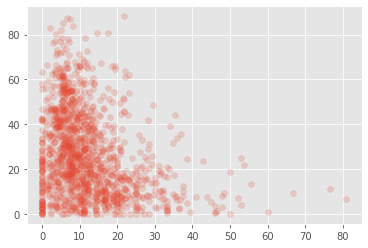

In [43]:
#Looked Interesting but Weak
fig, ax = plt.subplots()
ax.scatter(df['pct_hpss'], df['pct_poverty'], alpha = 0.2);


In [44]:
#Is there any correlation between pct hpss and pct poverty? 
r,_ = stats.spearmanr(df['pct_hpss'], df['pct_poverty'])
r

-0.28712484879281513

## MLE for Poisson - modeling pct hpss based on poverty classification

Start: Model percent hpss for high poverty areas
high_pov['pct_hpss']

Poisson model
looking for maximum likelihood value of lmbda given the data
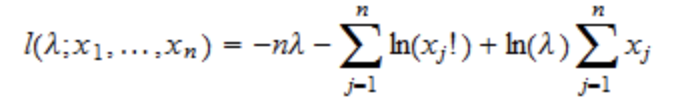



In [45]:
#most likely lambda is mean of data collected (only 1 parameter for poisson)

In [46]:
import math 
def log_likelihood_poisson(data, mu):
    log_lik = -len(data)*mu
    for datum in data:
        log_lik -= math.log(math.factorial(datum)) - (np.log(mu)) * (datum)
    return log_lik

In [47]:
# Get approx range for mu for high pov and pct hpss --> note can't do for others 
#because non integral values....what should I do?  convert to int? 

lams = np.arange(30, 40, 0.5)
y = np.array(high_pov['tot_lpss']).astype(int)

for lam in lams:
    print(f"lam: {lam}, log-likelihood: {log_likelihood_poisson(y, lam)}")
 

lam: 30.0, log-likelihood: -5519.908655232734
lam: 30.5, log-likelihood: -5475.779403205672
lam: 31.0, log-likelihood: -5438.376128910178
lam: 31.5, log-likelihood: -5407.483587056928
lam: 32.0, log-likelihood: -5382.896702286188
lam: 32.5, log-likelihood: -5364.419938410018
lam: 33.0, log-likelihood: -5351.866715809279
lam: 33.5, log-likelihood: -5345.058872639207
lam: 34.0, log-likelihood: -5343.8261659516775
lam: 34.5, log-likelihood: -5348.00580923675
lam: 35.0, log-likelihood: -5357.442043235528
lam: 35.5, log-likelihood: -5371.985737196716
lam: 36.0, log-likelihood: -5391.4940180209305
lam: 36.5, log-likelihood: -5415.829924981232
lam: 37.0, log-likelihood: -5444.862087937504
lam: 37.5, log-likelihood: -5478.464427145918
lam: 38.0, log-likelihood: -5516.515872953526
lam: 38.5, log-likelihood: -5558.900103812057
lam: 39.0, log-likelihood: -5605.5053011982545
lam: 39.5, log-likelihood: -5656.223920143764


In [48]:
lams = np.arange(20, 30, 0.5)
y = np.array(not_high_pov['tot_lpss']).astype(int)

for lam in lams:
    print(f"lam: {lam}, log-likelihood: {log_likelihood_poisson(y, lam)}")
 

lam: 20.0, log-likelihood: -6121.102748288606
lam: 20.5, log-likelihood: -6061.3564819387875
lam: 21.0, log-likelihood: -6010.086859695095
lam: 21.5, log-likelihood: -5966.894924086877
lam: 22.0, log-likelihood: -5931.409236976049
lam: 22.5, log-likelihood: -5903.283405363439
lam: 23.0, log-likelihood: -5882.193879154508
lam: 23.5, log-likelihood: -5867.837985781955
lam: 24.0, log-likelihood: -5859.93217175876
lam: 24.5, log-likelihood: -5858.210425555856
lam: 25.0, log-likelihood: -5862.422859817717
lam: 25.5, log-likelihood: -5872.334433983697
lam: 26.0, log-likelihood: -5887.723800949256
lam: 26.5, log-likelihood: -5908.382263591746
lam: 27.0, log-likelihood: -5934.112828833575
lam: 27.5, log-likelihood: -5964.729348505111
lam: 28.0, log-likelihood: -6000.055737619454
lam: 28.5, log-likelihood: -6039.925261838477
lam: 29.0, log-likelihood: -6084.179886907941
lam: 29.5, log-likelihood: -6132.669683704656


### APPROXIMATE RANGE: 
lambdas: 
    between 33.5 - 34.5 for high pov tot_lpss
    between 24 - 25 for not high pov tot_lpss

In [49]:
def mle_poisson(data, lams):
    log_liks = []
    y = np.array(data).astype(int)
    for lam in lams:
        log_liks.append(log_likelihood_poisson(y, lam))
    idx = np.argmax(log_liks)
    return lams[idx]
        

In [50]:
lams = np.arange(33.5, 34.5, .02)
lmbda_lpss_highpov = mle_poisson(high_pov['tot_lpss'], lams)
print(f"Lambda: High Pov (Total LPSS) {lmbda_lpss_highpov.round(3)}")

Lambda: High Pov (Total LPSS) 33.86


In [51]:
lams = np.arange(24, 25, .02)
lmbda_lpss_notpov = mle_poisson(not_high_pov['tot_lpss'], lams)
print(f"Lambda: NOT High Pov (Total LPSS) {lmbda_lpss_notpov.round(5)}")

Lambda: NOT High Pov (Total LPSS) 24.4


### Conclusion: poisson is not a good model for the data (see how fits)

Normal does not seem good either because drops off at 0 and has long right tail
Poisson might not be good because of the "weights" - there is error.  
Looks like beta distribution but don't know how to do that.  

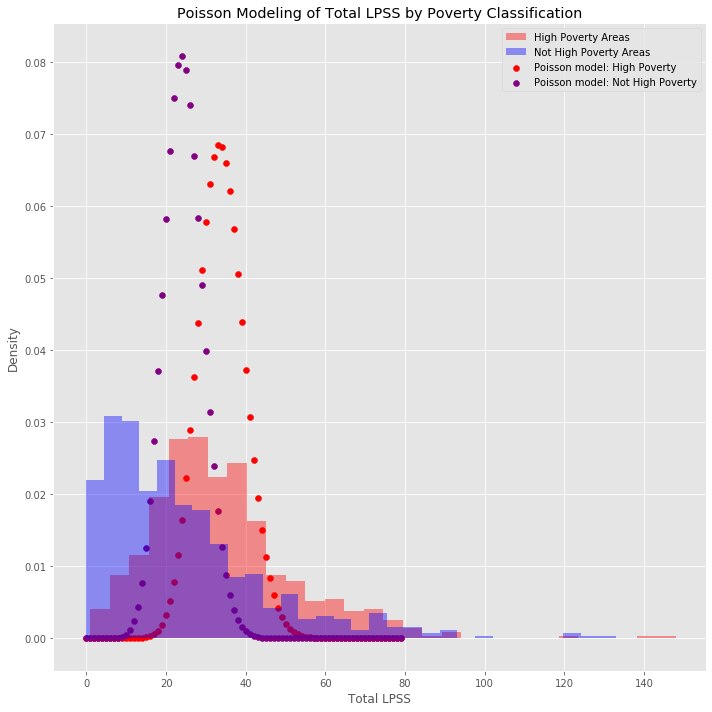

In [52]:
fig, ax = plt.subplots(figsize = (10, 10))
x = np.arange(0, 80, 1)
ax.hist(high_pov['tot_lpss'], alpha = 0.4,  color = 'red', label = 'High Poverty Areas', bins = 30, density = True)
ax.hist(not_high_pov['tot_lpss'], alpha = 0.4, color = 'blue', label = 'Not High Poverty Areas', density = True, bins = 30)
ax.scatter(x, stats.poisson(mu = lmbda_lpss_highpov).pmf(x), color = 'red', label = 'Poisson model: High Poverty')
ax.scatter(x, stats.poisson(mu = lmbda_lpss_notpov).pmf(x), color = 'purple', label = 'Poisson model: Not High Poverty')
ax.legend()
ax.set_xlabel ('Total LPSS')
# ax.set_xlim(0,100)
ax.set_title('Poisson Modeling of Total LPSS by Poverty Classification')
ax.set_ylabel('Density')
fig.tight_layout()
# fig.savefig('images/Poisson_model_exploration.jpeg');

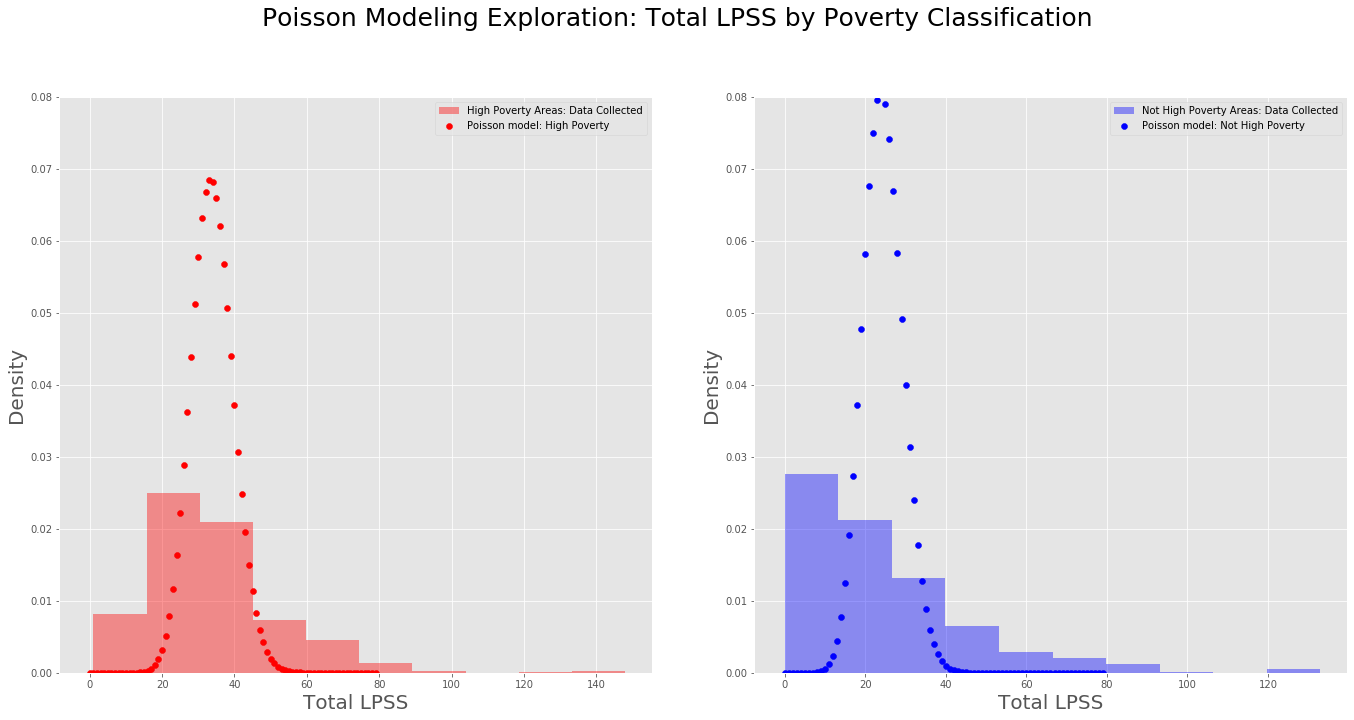

In [53]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
x = np.arange(0, 80, 1)
data = [high_pov['tot_lpss'], not_high_pov['tot_lpss']]
d_labels = ['High Poverty Areas: Data Collected', 'Not High Poverty Areas: Data Collected']
models = [stats.poisson(mu = lmbda_lpss_highpov), stats.poisson(mu = lmbda_lpss_notpov)]
m_labels = ['Poisson model: High Poverty', 'Poisson model: Not High Poverty']
colors = ['red', 'blue']
color2 = ['red', 'blue']


for ax, datum, dlab, mod, mlab, col, col2 in zip(axs.flatten(), data, d_labels, models, m_labels, colors, color2):
    ax.hist(datum, alpha = 0.4, label = dlab, density = True, color = col)
    ax.scatter(x, mod.pmf(x), label = mlab, color = col)
    ax.legend()
    ax.set_ylabel('Density', fontsize = 20)
    ax.set_ylim(0, 0.08)
    ax.set_xlabel ('Total LPSS', fontsize = 20)
 


fig.suptitle('Poisson Modeling Exploration: Total LPSS by Poverty Classification', fontsize = 25, y = 1.05)
fig.tight_layout(pad = 5)
# fig.savefig('../images/poisson_modeling_lpss_sidebyside.jpeg')

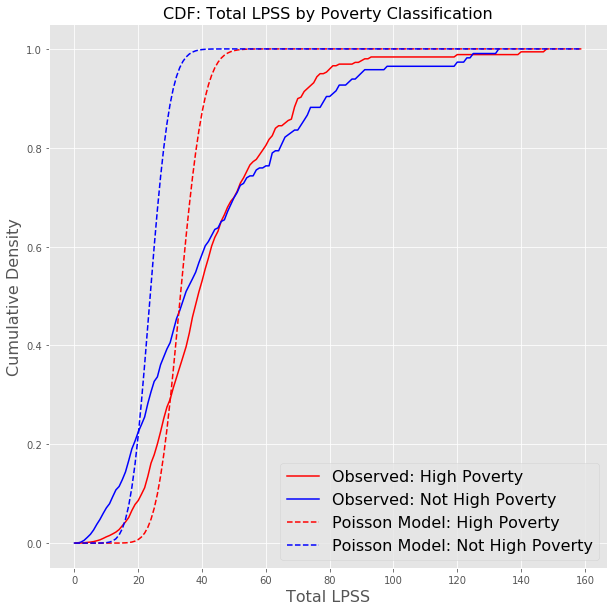

In [56]:
fig, ax = plt.subplots(figsize = (10, 10))
labels = ['High Poverty', 'Not High Poverty']
colors = ['red', 'blue']
dfs = [high_pov, not_high_pov]
columns_c = ['tot_lpss', 'tot_lpss']
labels_c = ['Observed: High Poverty', 'Observed: Not High Poverty']
ax.set_xlabel('Total LPSS', fontsize = 16)
ax.set_ylabel('Cumulative Density', fontsize = 16)

overlay_plots(ax, dfs_c, columns_c, labels_c, colors, 'CDFs: Total LPSS by Poverty Classification')

x = np.arange(0, 160, 1)
ax.plot(stats.poisson(mu = lmbda_lpss_highpov).cdf(x), color = 'red', linestyle = 'dashed', label = 'Poisson Model: High Poverty')
ax.plot(stats.poisson(mu = lmbda_lpss_notpov).cdf(x), color = 'blue', linestyle = 'dashed', label = 'Poisson Model: Not High Poverty')
ax.legend(fontsize = 16)
ax.set_title('CDF: Total LPSS by Poverty Classification', fontsize = 16);
# fig.savefig('../images/poisson_cdfs.jpeg')

### Explore Map Visualization

In [53]:
from folium.plugins import HeatMap

In [54]:
import geopandas as gpd
from splot.mapping import vba_choropleth
%matplotlib inline

gdf = gpd.read_file("../data/Philadelphia_Census_Tracts_2010_201302.geojson")
gdf.head()

,NAME10,AWATER10,TRACTCE10,OBJECTID,GEOID10,ALAND10,STATEFP10,FUNCSTAT10,NAMELSAD10,COUNTYFP10,INTPTLAT10,Shape_Leng,LOGRECNO,MTFCC10,INTPTLON10,geometry
0,50,3340294.0,005000,46.0,42101005000,4504459.0,42,S,Census Tract 50,101,+39.8898768,48033.335048,10389,G5020,-075.1691412,"POLYGON ((-75.17214 39.88129, -75.17505 39.881..."
1,54,530013.0,005400,47.0,42101005400,1846253.0,42,S,Census Tract 54,101,+39.8904539,24624.823144,10390,G5020,-075.2513923,"POLYGON ((-75.24623 39.88951, -75.24799 39.887..."
2,55,12010.0,005500,48.0,42101005500,1168442.0,42,S,Census Tract 55,101,+39.9074191,20389.059940,10391,G5020,-075.2489174,"POLYGON ((-75.25129 39.90440, -75.25297 39.905..."
3,56,0.0,005600,49.0,42101005600,840411.0,42,S,Census Tract 56,101,+39.8988328,11788.147571,10392,G5020,-075.2447347,"POLYGON ((-75.24184 39.90383, -75.24140 39.903..."
4,60,0.0,006000,50.0,42101006000,1089657.0,42,S,Census Tract 60,101,+39.9115196,14205.267812,10393,G5020,-075.2381570,"POLYGON ((-75.23341 39.91384, -75.23273 39.913..."


In [55]:
gdf['GEOID10'] = gdf['GEOID10'].astype('int')


In [56]:
df_temp = df.groupby('geoid-tract').mean().reset_index()
df_temp.head()

,geoid-tract,geoid,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,pct_vehicle_avail,tot_restaurants,pct_poverty,area,length
0,42101000100,4.210100e+11,53.0,25.171607,9.750,4.597293,15.217095,73.296943,75.5,7.069226,601133.541016,3575.245416
1,42101000200,4.210100e+11,120.0,44.726053,17.750,6.615729,12.885662,51.782178,105.0,37.607506,651697.152344,3688.952987
2,42101000300,4.210100e+11,91.0,77.748090,17.625,14.074331,16.904494,55.979566,30.0,8.553767,466075.953125,3022.723733
3,42101000401,4.210100e+11,74.0,28.115502,20.000,7.598784,21.276596,46.686391,30.0,18.465046,397938.730469,2734.052343
4,42101000402,4.210100e+11,99.5,59.460116,22.875,13.808700,18.907992,55.518205,86.0,3.624679,258701.769531,2343.651605


In [57]:
new = df_temp.merge(gdf, how = 'inner', left_on='geoid-tract', right_on = 'GEOID10')

In [58]:
new.describe()

,geoid-tract,geoid,tot_lpss,lpss_per_1000,tot_hpss,hpss_per_1000,pct_hpss,pct_vehicle_avail,tot_restaurants,pct_poverty,area,length,AWATER10,OBJECTID,GEOID10,ALAND10,Shape_Leng
count,3.720000e+02,3.720000e+02,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,3.720000e+02,372.000000,3.720000e+02,372.000000,3.720000e+02,3.720000e+02,372.000000
mean,4.210102e+10,4.210102e+11,29.601661,28.786218,4.235065,3.900238,13.173421,68.398464,6.347289,25.787033,5.087000e+05,2936.862309,2.680683e+04,189.981183,4.210102e+10,7.608938e+05,12719.586700
std,1.171883e+04,1.171883e+05,21.412660,20.817832,4.965144,4.291701,10.070781,17.155509,13.209500,15.516432,7.709266e+05,1807.631303,1.654161e+05,110.504343,1.171883e+04,5.980389e+05,5663.220025
min,4.210100e+10,4.210100e+11,1.000000,0.643087,0.000000,0.000000,0.000000,23.969792,0.000000,0.755858,6.508593e+04,1073.898994,0.000000e+00,1.000000,4.210100e+10,9.995800e+04,4342.558559
25%,4.210101e+10,4.210101e+11,14.250000,12.042416,1.656250,1.363409,6.340056,54.536736,1.702381,12.780189,1.859406e+05,1894.301482,0.000000e+00,94.750000,4.210101e+10,3.933758e+05,8940.254686
50%,4.210102e+10,4.210102e+11,26.416667,25.902942,2.937500,2.899669,10.453672,69.471318,3.291667,24.105450,2.733757e+05,2370.756281,0.000000e+00,189.500000,4.210102e+10,5.905945e+05,11184.116834
75%,4.210103e+10,4.210103e+11,39.895833,39.892333,4.517857,4.340113,17.456912,82.847447,5.850000,36.250470,4.787813e+05,3247.805029,0.000000e+00,283.250000,4.210103e+10,9.039960e+05,14571.064123
max,4.210104e+10,4.210104e+11,148.000000,110.190555,30.250000,31.515315,66.666667,100.000000,145.000000,66.848087,7.684545e+06,15886.036994,1.936838e+06,384.000000,4.210104e+10,4.501110e+06,43156.256838


In [59]:
import folium.plugins

philly_geo = '../data/Philadelphia_Census_Tracts_2010_201302.geojson'

m = folium.Map(location=[39.9509, -75.1575], zoom_start=13, tiles = 'StamenToner')


max_amount = (new['tot_lpss']).max()



hm_wide = HeatMap(list(zip(new.INTPTLAT10.values, new.INTPTLON10.values, new.tot_lpss.values)),
                   min_opacity=0.4,
                   max_val=max_amount,
                   radius=30, blur=15, 
                   max_zoom=1, 
                 ).add_to(m)

# folium.Marker([39.9509, -75.1575], popup='Center City', icon=folium.Icon(color='green')).add_to(m)

# folium.CircleMarker([39.9409, -75.1630],
#                     radius=80,
#                     popup='Center City',
#                     color='black',
#                     ).add_to(m)

m.add_child(hm_wide)
# m.save('images/philly_heat_map_tot_lpss.html')

In [60]:
m

In [61]:
philly_geo = '../data/Philadelphia_Census_Tracts_2010_201302.geojson'

m = folium.Map(location=[39.9509, -75.1575], zoom_start=12, tiles = 'StamenToner')


max_amount = (new['pct_poverty']).max()



hm_wide = HeatMap(list(zip(new.INTPTLAT10.values, new.INTPTLON10.values, new.pct_poverty.values)),
                   min_opacity=0.4,
                   max_val=max_amount,
                   radius=30, blur=15, 
                   max_zoom=1, 
                 ).add_to(m)

m.add_child(hm_wide)
m

#### What is the difference between the 20 poorest blockgroups and the 20 "least poor" block groups

In [62]:
pct_pov_above_80 = df[df['pct_poverty']>70]
pct_pov_below_10 = df[df['pct_poverty']<5]


''

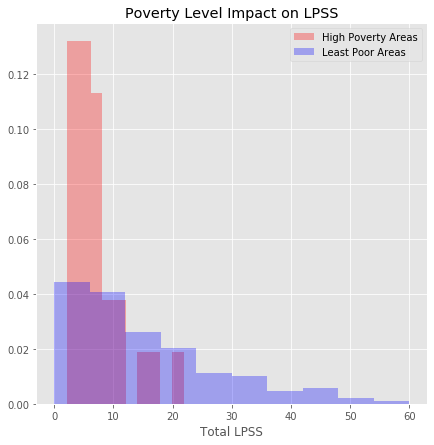

In [63]:
fig, ax = plt.subplots(figsize = (7,7))

data = [pct_pov_above_80['pct_hpss'], pct_pov_below_10['pct_hpss']]
labels = ['High Poverty Areas', 'Least Poor Areas']
colors = ['red', 'blue']

#from functionalization.py
overlay_histograms(ax, data, labels, colors, xlabel = 'Total LPSS', title = 'Poverty Level Impact on LPSS', bin_size = 10)
;

In [64]:
pct_pov_above_80['pct_hpss'].mean()


7.32156033037037

In [65]:
pct_pov_below_10['pct_hpss'].mean()

15.208826490136055

Final exploration: excluding Center City, Temple, and University City

In [66]:
exp = pd.read_csv('../data/food_retail_cleaned.csv')

In [67]:
exp = exp.drop('Unnamed: 0', axis = 1)

In [68]:
e = exp.merge(gdf, how = 'inner', left_on='geoid-tract', right_on = 'GEOID10')

In [69]:
e.columns



Index(['geoid', 'non_res', 'tot_lpss', 'lpss_per_1000', 'tot_hpss',
       'hpss_per_1000', 'pct_hpss', 'hpss_access', 'sprmkt_access',
       'pct_vehicle_avail', 'tot_restaurants', 'pct_poverty', 'high_poverty',
       'area', 'length', 'geoid-tract', 'NAME10', 'AWATER10', 'TRACTCE10',
       'OBJECTID', 'GEOID10', 'ALAND10', 'STATEFP10', 'FUNCSTAT10',
       'NAMELSAD10', 'COUNTYFP10', 'INTPTLAT10', 'Shape_Leng', 'LOGRECNO',
       'MTFCC10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [70]:
e['NAME10']= e['NAME10'].astype(float)

In [71]:
f = e[e['NAME10']>170]


Plot below is interesting but since I don't have exact locations by tract to filter accurately, I'll hold for a later exploration.

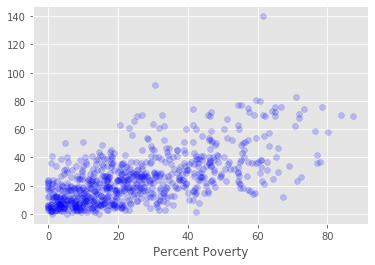

In [72]:
fig, ax = plt.subplots()
ax.scatter(f['pct_poverty'], f['tot_lpss'], alpha = 0.2, color = 'blue')
ax.set_xlabel('Percent Poverty');

In [73]:
f['tot_lpss'].mean()

24.204755614266844